# Quantum approximate optimisation algorithm (QAOA) applied to maxcut.

## The Max-Cut problem

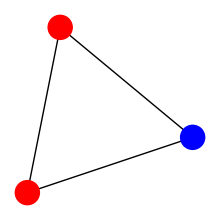

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from([(0, 1), (1, 2), (2, 0)])
plt.figure(figsize=(2, 2))
nx.draw(G, node_color=["red", "blue", "red"])
plt.show()

There are $2^3$ possible assignments of colour to nodes. In general there are $2^n$. The Max-cut problem can then be stated as that of finding the colour assignment which maximises the number of edges between vertices of a different colour.

## Quantum Approximate Optimization Algorithm (QAOA)

Introduced in 'A Quantum Approximate Optimization Algorithm' (found at https://arxiv.org/abs/1411.4028). The idea is to prepare a quantum state which encodes a solution to the Max-cut problem.


This is a variational algorithm, which is to say that a paramaterised state is prepared, with the parameters varied to improve the solution. We will have $2p$ parameters where p is our number of layers. In particular, the state prepared has the form 


$$
| \psi  ( \beta, \gamma ) \rangle = U ( \beta_m ) U ( \gamma_m ) ... U (\beta_0) U ( \gamma_0 ) | \psi_0 \rangle
$$

where

$$
U( \beta_i ) = e^{i \beta H_B} \quad \& \quad U ( \gamma_i) = e^{i \gamma H_P}
$$

with $H_P$ depending on the problem instance. 

## Cost function for Maxcut
$$
\begin{equation}
C= \sum_{(i,\,j)} x_i(1-x_j)
\end{equation}
$$

For the previous 3 vertex graph the *problem Hamiltonian* is

$$
H_P = \frac{3}{2} I - \frac{1}{2} \Big[ ( Z \otimes Z \otimes I ) + ( Z \otimes I \otimes Z ) + ( I \otimes Z \otimes Z ) \Big]
$$

where you will notice that there is a $ Z \otimes Z$ acting between each vertex which is connected by an edge.

The *mixer Hamiltonian* has the form 

$$
H_B =   ( X \otimes I \otimes I ) + ( I \otimes X \otimes I ) + ( I \otimes I \otimes X )
$$

where you will notice that there is an $X$ operator acting on each vertex.

## The cost function for Maxcut

A solution to maxcut can be found by maximising the following cost function $C$ .



$$
\begin{equation}
C= \sum_{(i,j)} x_i(1-x_j)
\end{equation}
$$

Here $x_i$ and $x_j$ are the the "colours" of each vertex.  

$$
\begin{equation}
x_i,x_j \in \{0,1\}
\end{equation}
$$

$x_i(1-x_j)=0$ if $x_i=x_j$ and $ x_i(1-x_j)=1$ if the terms are not equal.

We want to encode our Maxcut cost function as a Hamiltonain. To do this we can perform the following translation.

$$
\begin{equation}
x_i \mapsto \frac{1}{2}(I-Z_i)
\end{equation}
$$


The Pauli Z operator can be used to distinguish between the $|0\rangle$ and $|1\rangle$ basis states as these are eigenstates with eigenvalues $\pm 1$ .

$$
\begin{equation}
H_P = \frac{1}{2}\sum_{(i, \,j)} (I-Z_i \,Z_j)
\end{equation}
$$


$$
\begin{equation}
H_B = \sum_i X_i
\end{equation}
$$

Here we use the the convention that $X_i$ means a Pauli X operator will be applied to the "ith" qubit and the identity operator will be applied to all other qubits in the circuit.

In [2]:
import warnings

warnings.filterwarnings("ignore")

# Circuit Construction for QAOA

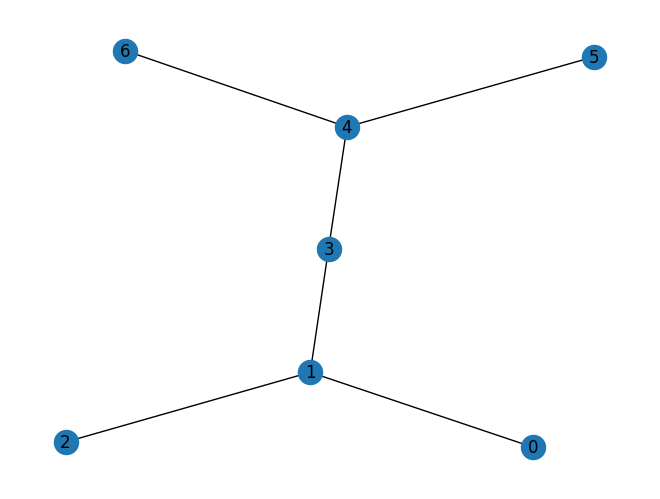

In [3]:
import networkx as nx

max_cut_graph_edges = [(0, 1), (1, 2), (1, 3), (3, 4), (4, 5), (4, 6)]
n_nodes = 7

max_cut_graph = nx.Graph()
max_cut_graph.add_edges_from(max_cut_graph_edges)
nx.draw(max_cut_graph, labels={node: node for node in max_cut_graph.nodes()})

expected_results = [(0, 1, 0, 0, 1, 0, 0), (1, 0, 1, 1, 0, 1, 1)]

## Define Cost Hamiltonian: $\gamma H$

$$
\begin{equation}
H_P = \frac{1}{2}\sum_{(i, \, j)} (I -Z_i \,Z_j)
\end{equation}
$$

$$
\begin{equation}
H_P = 3 I^{\otimes 7} -0.5 \big[ Z_0 Z_1 + Z_1 Z_2 +Z_1 Z_3 +Z_3 Z_4 +Z_4 Z_5 +Z_4 Z_6  \big]
\end{equation}
$$

Using the same index convention as above

## Hamiltonian Circuit

## Construction of the Mixer Hamiltonian: $\beta B$

## Define the Initial State

In [4]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter as draw


def qaoa_initial_circuit(n_qubits: int) -> Circuit:
    c = Circuit(n_qubits)
    for i in range(n_qubits):
        c.H(i)
    return c


superposition_circuit = qaoa_initial_circuit(n_nodes)

draw(superposition_circuit)

## Construct QAOA Circuit

In [5]:
from pytket import Circuit


def build_cost_layer(graph: nx.Graph, gamma_val: float) -> Circuit:
    circ = Circuit(graph.number_of_nodes())

    for i, j in graph.edges:
        circ.ZZPhase(-gamma_val / 2, i, j)

    return circ

In [6]:
def build_mixer_layer(n_vertices: int, beta_val: float) -> Circuit:
    circ = Circuit(n_vertices)

    for qubit in circ.qubits:
        circ.Rx(beta_val, qubit)

    return circ

Now lets define a function to create our entire QAOA circuit. For $p$ QAOA layers we expect that our circuit will require $2p$ parameters. Here we will pass and cost mixer parameters in as a list where the length of the list defines the number of layers.

In [7]:
def build_qaoa_circuit(
    graph: nx.Graph, mixer_angles: list[float], cost_angles: list[float]
) -> Circuit:

    n_nodes = graph.number_of_nodes()

    assert len(mixer_angles) == len(cost_angles)

    qaoa_circuit = qaoa_initial_circuit(n_nodes)

    # Iteratively append "p" cost and mixer layers
    for cost_angle, mixer_angle in zip(cost_angles, mixer_angles):
        qaoa_circuit.append(build_cost_layer(graph, cost_angle))
        qaoa_circuit.add_barrier(list(range(n_nodes)))
        qaoa_circuit.append(build_mixer_layer(n_nodes, mixer_angle))

    qaoa_circuit.measure_all()
    return qaoa_circuit

In [8]:
from networkx import path_graph

three_vertex_path = path_graph(3)

draw(build_qaoa_circuit(three_vertex_path, [0.8, 0.1], [0.75, 0.6]))

We also need to extract our energy expectation values from a `BackendResult` object after our circuit is processed by the device/simulator. We do this with the `energy_from_result` function below. Note that the fact that the maxcut Hamiltonian contains only commuting terms means that we do not need to calculate our energy expectation using multiple measurement circuits. This may not the the case for a different problem Hamiltonian.

In [9]:
from pytket.backends.backendresult import BackendResult


def energy_from_result(graph: nx.Graph, results: BackendResult) -> float:
    energy = 0.0
    dist = results.get_distribution()
    for i, j in graph.edges:
        energy += sum((meas[i] ^ meas[j]) * prob for meas, prob in dist.items())

    return energy

In [10]:
from pytket.backends.backend import Backend
from pytket.passes import RemoveBarriers
from typing import Callable
import numpy as np


def eval_qaoa_energy(
    backend: Backend,
    compiler_pass: Callable[[Circuit], bool],
    guess_mixer_angles: np.array,
    guess_cost_angles: np.array,
    graph: nx.Graph,
    seed: int,
    shots: int = 5000,
) -> tuple[float, BackendResult]:

    # Build Circuit
    qaoa_circuit = build_qaoa_circuit(
        graph=graph, cost_angles=guess_cost_angles, mixer_angles=guess_mixer_angles
    )

    # Compile
    RemoveBarriers().apply(qaoa_circuit)
    compiler_pass(qaoa_circuit)

    # Execute
    result: BackendResult = backend.run_circuit(qaoa_circuit, shots, seed=seed)

    return energy_from_result(graph, result), result

## Optimise Energy by Guessing Parameters

In [11]:
def solve_maxcut_instance(
    graph: nx.Graph,
    compiler_pass: Callable[[Circuit], bool],
    backend: Backend,
    iterations: int = 100,
    p_value: int = 3,
    n_shots: int = 5000,
    seed: int = 12345,
) -> tuple[BackendResult, np.array, np.array]:

    highest_energy = 0
    best_guess_mixer_angles = [0 for _ in range(p_value)]
    best_guess_cost_angles = [0 for _ in range(p_value)]

    rng = np.random.default_rng(seed)

    for _ in range(iterations):
        guess_mixer_angles = rng.uniform(0, 1, p_value)
        guess_cost_angles = rng.uniform(0, 1, p_value)
        qaoa_energy, result = eval_qaoa_energy(
            backend,
            compiler_pass,
            guess_mixer_angles,
            guess_cost_angles,
            seed=seed,
            shots=n_shots,
            graph=graph,
        )

        if qaoa_energy > highest_energy:
            print("new highest energy found: ", qaoa_energy)

            best_guess_mixer_angles = np.round(guess_mixer_angles, 3)
            best_guess_cost_angles = np.round(guess_cost_angles, 3)
            highest_energy = qaoa_energy
            best_result: BackendResult = result

    print("highest energy: ", highest_energy)
    print("best guess mixer angles: ", best_guess_mixer_angles)
    print("best guess cost angles: ", best_guess_cost_angles)
    best_outputs = tuple([best_result, best_guess_cost_angles, best_guess_mixer_angles])
    return best_outputs

## Calculate the State for the final Parameters

In [12]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()
comp = backend.get_compiled_circuit

In [13]:
%%time
qaoa_result, cost_angles, mixer_angles = solve_maxcut_instance(
    backend=backend,
    compiler_pass=backend.default_compilation_pass(2).apply,
    n_shots=5000,
    iterations=100,
    graph=max_cut_graph,
    seed=12345,
)

new highest energy found:  3.1432
new highest energy found:  3.283599999999999
new highest energy found:  4.361
new highest energy found:  4.925600000000001
new highest energy found:  4.941999999999999
highest energy:  4.941999999999999
best guess mixer angles:  [0.392 0.247 0.138]
best guess cost angles:  [0.592 0.738 0.608]
CPU times: user 2min 17s, sys: 33.2 s, total: 2min 50s
Wall time: 43.2 s


Success ratio 0.4246 


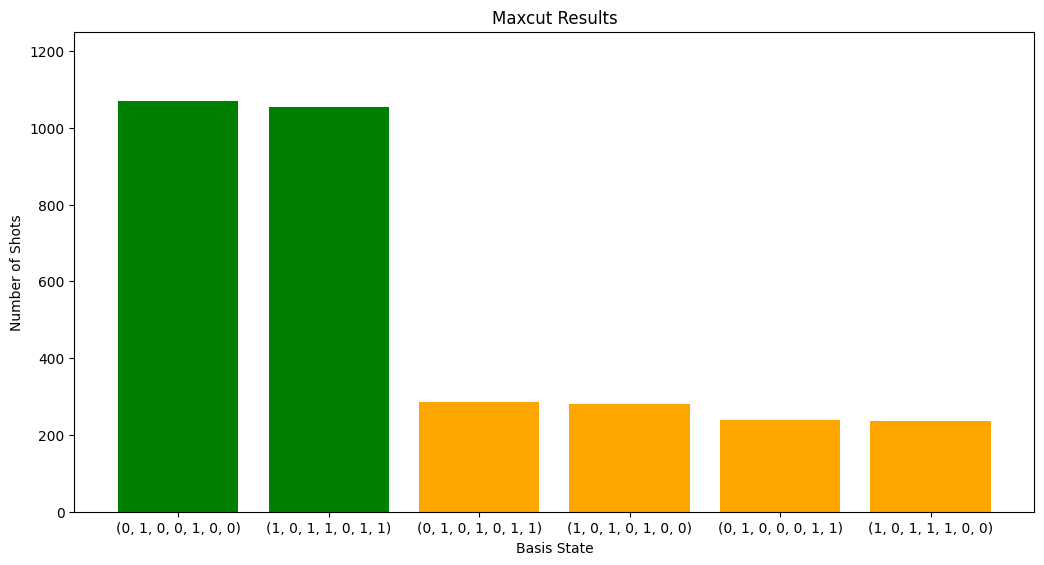

In [14]:
import matplotlib.pyplot as plt


def plot_maxcut_results(result: BackendResult, n_strings: int) -> None:
    """
    Plots Maxcut results in a barchart with the two most common bitstrings highlighted in green.
    """
    counts_dict = result.get_counts()
    sorted_shots = counts_dict.most_common()
    n_shots = sum(counts_dict.values())

    n_most_common_strings = sorted_shots[:n_strings]
    x_axis_values = [str(entry[0]) for entry in n_most_common_strings]  # basis states
    y_axis_values = [entry[1] for entry in n_most_common_strings]  # counts
    num_successful_shots = sum(y_axis_values[:2])
    print(f"Success ratio {num_successful_shots/n_shots} ")

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1.5, 1])
    color_list = ["green"] * 2 + (["orange"] * (len(x_axis_values) - 2))
    ax.bar(
        x=x_axis_values,
        height=y_axis_values,
        color=color_list,
    )
    ax.set_title(label="Maxcut Results")
    plt.ylim([0, 0.25 * n_shots])
    plt.xlabel("Basis State")
    plt.ylabel("Number of Shots")
    plt.show()


plot_maxcut_results(qaoa_result, 6)

Here the binary strings in the results correspond to the two optimal colourings of our graph.

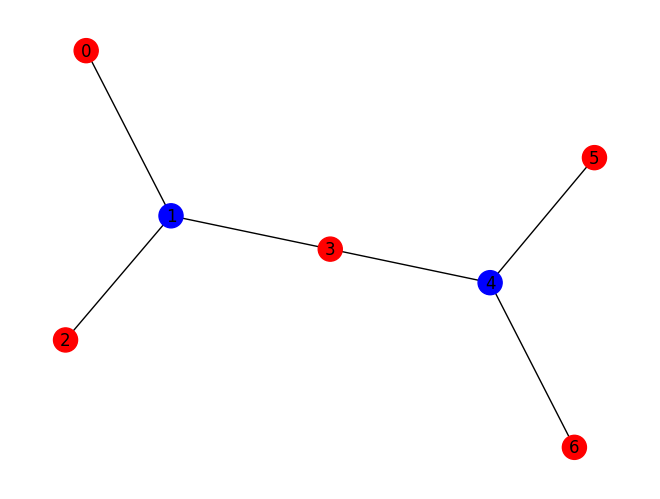

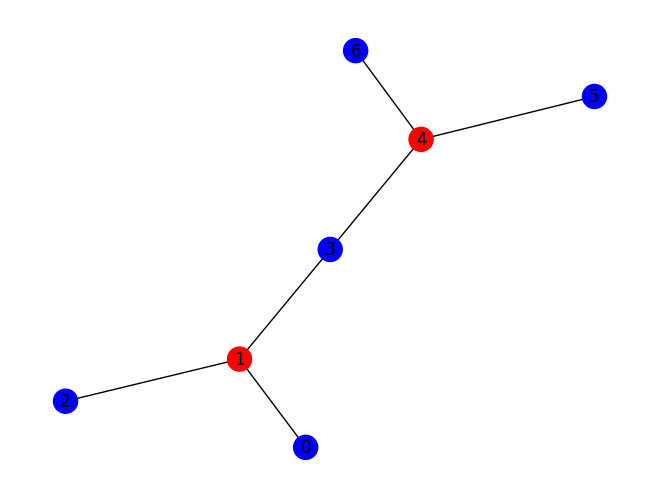

In [15]:
G = nx.Graph()
G.add_edges_from(max_cut_graph_edges)

H = nx.Graph()
H.add_edges_from(max_cut_graph_edges)

plt.figure(1)
nx.draw(
    G,
    labels={node: node for node in max_cut_graph.nodes()},
    node_color=["red", "blue", "red", "red", "blue", "red", "red"],
)
plt.figure(2)
nx.draw(
    H,
    labels={node: node for node in max_cut_graph.nodes()},
    node_color=["blue", "red", "blue", "blue", "red", "blue", "blue"],
)

plt.show()